In [85]:
from src.plotting import plot_sim_evaluation_pv

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import defaultdict
import seaborn as sns
sns.set_theme(palette="colorblind")
sns.set_style("white", {'axes.grid': False})

t = 2.5

SMALL_SIZE = 10 * t
MEDIUM_SIZE = 12 * t
BIGGER_SIZE = 14 * t

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
from evaluation.statistic_testing.basics import basic_configs
from evaluation.statistic_testing.basics import basic_metrics
from evaluation.statistic_testing.basics import basic_models
from evaluation.statistic_testing.basics import basic_obs, basic_rews
from src.data import get_data, get_gmm, get_pv_data
from src.pv.pv import read_pv_data
from src.observations import minute_observation_stay
from src.pv.metrics import *
from gymportal.evaluation import *
from src.pv.rewards import *
from src.pv.observations import pv_observation_mean
from gymportal.environment import *
from src.pv.pv import read_pv_data
import pytz
from datetime import datetime, timedelta
from gymportal.sim import get_charging_network, Recomputer, EvaluationSimulator, SimGenerator
from gymportal.data.battery_generators import CustomizableBatteryGenerator
from acnportal.acnsim import Linear2StageBattery
from src.rewards import sparse_soc_reward
from src.utils import AV_pod_ids, get_generator, get_power_function
from gymportal.data.ev_generators import get_standard_generator, RealWorldGenerator

timezone = pytz.timezone("America/Los_Angeles")


charging_network = get_charging_network(
    'simple_acn',
    basic_evse=True,
    voltage=208,
    network_kwargs={
        'station_ids': AV_pod_ids,
        "aggregate_cap": (150 / 54) * len(AV_pod_ids),
    },
)

# charging_network = get_charging_network('caltech', basic_evse=True, voltage=208,
#                                         network_kwargs={"transformer_cap": 150})

battery_generator = CustomizableBatteryGenerator(
    voltage=208,
    period=1,
    battery_types=[
        Linear2StageBattery,
    ],
    max_power_function=get_power_function,
)

# ev_generator = RealWorldGenerator(
#    battery_generator=battery_generator, site='caltech', period=1)
ev_generator = get_generator(
    'caltech',
    get_gmm(), # TODO Use other GMM for out-of-distrbution
    battery_generator,
    seed=4645643, #42
    frequency_multiplicator=10, #10
    duration_multiplicator=1, #2
    data=get_data(),
)

df_pv = get_pv_data()
df_pv.describe()
df_pv.P /= 54 / len(charging_network.station_ids)

observation_objects = basic_obs(df_pv)
reward_objects = basic_rews(df_pv)


metrics = basic_metrics(df_pv)


configs = basic_configs(
    observation_objects=observation_objects,
    reward_objects=reward_objects,
    action=zero_centered_single_charging_schedule_normalized(),
    # timezone=timezone,
    charging_network=charging_network,
    ev_generator=ev_generator,
    start_date = datetime(2019, 1, 1, tzinfo=timezone),
)

configs

[{'observation_objects': [<gymportal.environment.observations.sim_observation.SimObservationFactory at 0x78a7ad873dc0>,
  'action_object': <gymportal.environment.actions.SimActionFactory at 0x78a6c937d1f0>,
  'reward_objects': [<gymportal.environment.rewards.SimReward at 0x78a6cc501fa0>,
  'meet_constraints': True,
  'simgenerator': <gymportal.sim.sim_generator.SimGenerator at 0x78a6c937dac0>},
 {'observation_objects': [<gymportal.environment.observations.sim_observation.SimObservationFactory at 0x78a7ad873dc0>,
  'action_object': <gymportal.environment.actions.SimActionFactory at 0x78a6c937d1f0>,
  'reward_objects': [<gymportal.environment.rewards.SimReward at 0x78a6cc501fa0>,
  'meet_constraints': True,
  'simgenerator': <gymportal.sim.sim_generator.SimGenerator at 0x78a6c937deb0>},
 {'observation_objects': [<gymportal.environment.observations.sim_observation.SimObservationFactory at 0x78a7ad873dc0>,
  'action_object': <gymportal.environment.actions.SimActionFactory at 0x78a6c937d1f0

In [3]:
# # base_config = {
# #     "observation_objects": observation_objects,
# #     "action_object": zero_centered_single_charging_schedule_normalized(),
# #     "reward_objects": reward_objects,
# #     "meet_constraints": True,
# # }

# start_date = datetime(2019, 1, 1, tzinfo=timezone)
# dates = list(
#     map(
#         lambda x: start_date + timedelta(days=x),
#         range(14)
#     )
# )

# configs = [
#     base_config | {
#         "simgenerator":
#             SimGenerator(
#                 charging_network=charging_network,
#                 simulation_days=1,
#                 n_intervals=1,
#                 start_date=start_date,
#                 ev_generator=ev_generator,
#                 recomputer=Recomputer(recompute_interval=10, sparse=True),
#                 sim_class=EvaluationSimulator,
#             )
#     } for start_date in dates
# ]

In [4]:
from gymportal.evaluation import ACNSchedule
from acnportal.algorithms import UncontrolledCharging, SortedSchedulingAlgo, last_come_first_served, \
    first_come_first_served
from evaluation.statistic_testing.basics import basic_models
from src.cleanRL.agent import Agent, BetaAgent
from src.cleanRL.scheduler import CleanRLSchedule


# def load_agent(x, agent_class=Agent):
#     from utils import load_agent as ld
#     return ld(x, configs, agent_class)


# models = {
#     # "PPO": CleanRLSchedule(load_agent("RL_data/83219666-d196-4bb2-94d1-bf0d56b33df7/RL_454656")),
#     # "PPO-Beta": CleanRLSchedule(load_agent("RL_data/e6fd5bab-63ad-448d-90e0-842c239a1775/RL_454656", agent_class=BetaAgent)),
#     # "PPO-SoC": CleanRLSchedule(load_agent("RL_data/9f283b5a-8a3c-43d8-a59e-a574597c3824/RL_606208")),
#     # "PPO-SoC-Beta": CleanRLSchedule(load_agent("RL_data/6a095390-7c96-4a8c-b678-c161f94f65fb/RL_606208", agent_class=BetaAgent)),
#     "FCFS": ACNSchedule(SortedSchedulingAlgo(first_come_first_served)),
#     # "LCFS": ACNSchedule(SortedSchedulingAlgo(last_come_first_served)),
#     # "Uncontrolled": ACNSchedule(UncontrolledCharging()),
# }

models = basic_models(configs)
models

{'GCC': <src.cleanRL.scheduler.CleanRLSchedule at 0x78a6cc484430>,
 'BCC': <src.cleanRL.scheduler.CleanRLSchedule at 0x78a6cc5010a0>,
 'BSC': <src.cleanRL.scheduler.CleanRLSchedule at 0x78a6cc45e880>,
 'BSO': <src.cleanRL.scheduler.CleanRLSchedule at 0x78a6cc45e4c0>,
 'G-BC': <src.cleanRL.scheduler.CleanRLSchedule at 0x78a6c9391eb0>,
 'B-BC': <src.cleanRL.scheduler.CleanRLSchedule at 0x78a6c937d0a0>,
 'BSC+BC': <src.cleanRL.scheduler.CleanRLSchedule at 0x78a6cc3708e0>,
 'FCFS': <gymportal.evaluation.can_schedule.ACNSchedule at 0x78a6cc370b50>,
 'AUC': <gymportal.evaluation.can_schedule.ACNSchedule at 0x78a6cc370c10>}

In [5]:
models = {
    k: models[k] for k in ["AUC", "FCFS", "BCC", "BSC"]
}
models

{'AUC': <gymportal.evaluation.can_schedule.ACNSchedule at 0x78a6cc370c10>,
 'FCFS': <gymportal.evaluation.can_schedule.ACNSchedule at 0x78a6cc370b50>,
 'BCC': <src.cleanRL.scheduler.CleanRLSchedule at 0x78a6cc5010a0>,
 'BSC': <src.cleanRL.scheduler.CleanRLSchedule at 0x78a6cc45e880>}

In [6]:
configs = [configs[0]]

In [7]:
from src.actions import beta_one_for_all_schedule, beta_schedule_normalized
from src.utils import evaluate_model
from src.cleanRL.environment import make_env

__tuples = {}
for model_name, model in models.items():

    if isinstance(model, ACNSchedule):
        action = single_charging_schedule()
    elif model_name in ["BCC", "BSC", "B-BC", "BSC+BC"]:
        # ic(model_name)
        action = beta_schedule_normalized()
    elif model_name == "BSO":
        # ic(model_name)
        action = beta_one_for_all_schedule()
    else:
        action = zero_centered_single_charging_schedule_normalized()

    __tuples[model_name] = [
        evaluate_model(model,
                       make_env(cfg | {"action_object": action},
                                0.99, 0)(), 93242598,
                       ) for cfg in configs
    ]


# __tuples = {}
# for model_name, model in models.items():
#     ic(model_name)
#     __tuples[model_name] = []
#     for cfg in configs:
#         evaluate_model(model,
#                         make_env(cfg | {"action_object": single_charging_schedule()} if isinstance(
#                             model, ACNSchedule) else cfg, 0.99, 0)(), 93242598,
#                         )


simulations = {
    model_name: [v[0] for v in tuples] for model_name, tuples in __tuples.items()
}

agg_rewards = {
    model_name: [v[1] for v in tuples] for model_name, tuples in __tuples.items()
}


del __tuples

/home/y/git/acn-experiments/.venv/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/y/git/acn-experiments/.venv/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [114]:
import os
from functools import lru_cache
from typing import List, Dict, Any, Union, Optional

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from acnportal.acnsim import Simulator
from cycler import cycler
from matplotlib.colors import TABLEAU_COLORS
from matplotlib.figure import Figure
from mpl_toolkits.axes_grid1 import host_subplot

# from .decorators import save_fig
# from ..sim.simulators_custom import EvaluationSimulator


# @save_fig
def plot_training(results: Union[List[Dict[str, Any]], Dict[str, Any]]) -> Figure:
    if isinstance(results, dict):
        results = [results]

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), dpi=300)

    eval_ax = axes[0, 2]
    eval_metrics_ax = axes[1, 2]
    train_ax = axes[0, 0]
    train_metrics_ax = axes[1, 0]

    times_ax = axes[1, 1]
    steps_ax = axes[0, 1]

    eval_ax.set_title("Evaluation Rewards")
    eval_ax.set_xlabel('training interval')
    eval_ax.set_ylabel('reward')

    eval_metrics_ax.set_title("Evaluation Metrics")
    eval_metrics_ax.set_xlabel("training interval")
    eval_metrics_ax.set_ylabel('')

    train_ax.set_title("Training Rewards")
    train_ax.set_xlabel('episode')
    train_ax.set_ylabel('reward')

    train_metrics_ax.set_title("Training Metrics")
    train_metrics_ax.set_xlabel('episode')
    train_metrics_ax.set_ylabel('')

    times_ax.set_title('Sampler Performance')
    times_ax.set_xlabel('training interval')
    times_ax.set_ylabel('time in sec')

    steps_ax.set_title('Steps taken vs Steps trained')
    steps_ax.set_xlabel('training interval')
    steps_ax.set_ylabel('#steps')

    eval_rewards = []
    eval_metrics = {}

    train_rewards = results[-1]['hist_stats']['episode_reward']
    train_losses = []

    eval_times = []
    train_times = []
    iteration_times = []

    n_timesteps_agent = []
    n_trained_steps_agent = []

    n_timesteps_env = []
    n_trained_steps_env = []

    for d in results:
        if 'evaluation' in d:
            eval_rewards.append(d['evaluation']['hist_stats']['episode_reward'])

            for key, value in d['evaluation']['custom_metrics'].items():
                if key.endswith('_mean'):

                    if not key in eval_metrics:
                        eval_metrics[key] = []

                    eval_metrics[key].append(value)

            sampler_perf = d['evaluation']['sampler_perf']
            # eval_times.append(np.sum(
            #     [
            #         sampler_perf['mean_raw_obs_processing_ms'], sampler_perf['mean_inference_ms'],
            #         sampler_perf['mean_action_processing_ms'], sampler_perf['mean_env_wait_ms'],
            #         sampler_perf['mean_env_render_ms']
            #     ]
            # ))

        # train_rewards += d['hist_stats']['episode_reward']
        # train_losses.append(d['info']['learner']['__all__']['total_loss'])

        sampler_perf = d['sampler_perf']
        # train_times.append(np.sum(
        #     [
        #         sampler_perf['mean_raw_obs_processing_ms'], sampler_perf['mean_inference_ms'],
        #         sampler_perf['mean_action_processing_ms'], sampler_perf['mean_env_wait_ms'],
        #         sampler_perf['mean_env_render_ms']
        #     ]
        # ))

        iteration_times.append(d['time_this_iter_s'])

        n_timesteps_agent.append(d['num_agent_steps_sampled'])
        n_trained_steps_agent.append(d['num_agent_steps_trained'])

        n_timesteps_env.append(d['num_env_steps_sampled'])
        n_trained_steps_env.append(d['num_env_steps_trained'])

    means = np.mean(eval_rewards, axis=1)
    stds = np.std(eval_rewards, axis=1)

    eval_ax.plot(means, label='mean episode reward', color='tab:green', linestyle='--', marker='o')
    eval_ax.fill_between(x=range(len(means)), y1=means - stds, y2=means + stds,
                         color='tab:green', alpha=0.2, label='+/- 1$\sigma$')
    eval_ax.set_xticks(range(len(means)))

    eval_metrics_ax_legend = False
    for key, value in eval_metrics.items():
        eval_metrics_ax_legend = True
        eval_metrics_ax.plot(value, label=f"mean {key.split('_mean')[0]}", linestyle='--', marker='o')

    eval_metrics_ax.set_xticks(range(len(means)))
    if eval_metrics_ax_legend:
        eval_metrics_ax.legend()

    train_metrics_ax_legend = False
    for key, value in results[-1]['hist_stats'].items():
        if 'episode' in key or "policy" in key:
            continue
        train_metrics_ax_legend = True
        train_metrics_ax.plot(value, label=f"{key}", linestyle='--', marker='o')

    train_metrics_ax.set_xticks(range(len(means)))
    if train_metrics_ax_legend:
        train_metrics_ax.legend()

    train_ax.plot(train_rewards, color='tab:blue', linestyle='', marker='o', label='episode rewards')

    # plot linear approximation of training rewards
    x = np.arange(len(train_rewards))
    coef = np.polyfit(x, train_rewards, 1)
    poly1d_fn = np.poly1d(coef)
    train_ax.plot(x, poly1d_fn(x), linestyle='--')

    # train_metrics_ax.plot(train_losses, color='tab:orange', linestyle='--', marker='o', label='total loss')
    # train_metrics_ax.set_xticks(range(len(train_losses)))

    # times_ax.plot(train_times, color='tab:orange', label='agg. mean training')
    # times_ax.plot(eval_times, color='tab:green', label='agg. mean evaluation')
    # x = times_ax.twinx()
    times_ax.plot(iteration_times, color='tab:blue', label='iteration time', alpha=0.4, marker='x', linestyle='--')
    times_ax.plot(np.cumsum(iteration_times) / np.arange(1, len(iteration_times) + 1), color='tab:blue',
                  label='cumulative avg. of iteration time', marker='x', linestyle='--')
    times_ax.set_ylabel('time in sec')
    times_ax.set_xticks(range(len(iteration_times)))
    times_ax.legend()

    steps_ax.plot(n_timesteps_agent, label="n_timesteps_agent", linestyle=':', marker='x', alpha=0.5)
    steps_ax.plot(n_trained_steps_agent, label="n_trained_steps_agent", linestyle='--', marker='X', alpha=0.5)
    steps_ax.plot(n_timesteps_env, label="n_timesteps_env", linestyle=':', marker='.', alpha=0.5)
    steps_ax.plot(n_trained_steps_env, label="n_trained_steps_env", linestyle='--', marker='o', alpha=0.5)
    steps_ax.set_xticks(range(len(n_timesteps_agent)))
    steps_ax.legend()

    return fig


# @save_fig
def plot_evaluation(path, title=None) -> Figure:
    rewards_all = []
    steps_all = []
    ep_lengths_all = []
    jain_index_all = []
    percentage_soc_all = []
    proportion_of_energy_delivered_all = []
    model_names = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

    for model_name in model_names:
        with np.load(path + "/" + model_name + "/logs/" + "evaluations.npz") as data:
            rewards_all.append(data['episode_rewards'])
            steps_all.append(data['timesteps'].flatten())
            ep_lengths_all.append(data['episode_lengths'])
            jain_index_all.append(data['jain_index'])
            percentage_soc_all.append(data['percentage_soc'])
            proportion_of_energy_delivered_all.append(data['proportion_of_energy_delivered'])

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim((0, 1))

    colors = list(TABLEAU_COLORS.keys())
    markers = ['o', 's', 'x', '^', 'v', '.', 'D', '*', '4', '5']
    for i, (
            model_name, rewards, steps, ep_lengths, jain_index, percentage_soc,
            proportion_of_energy_delivered) in enumerate(
        zip(model_names, rewards_all, steps_all, ep_lengths_all, jain_index_all, percentage_soc_all,
            proportion_of_energy_delivered_all)):
        mean_rewards = np.mean(rewards, axis=1)
        std_rewards = np.std(rewards, axis=1)

        color = colors[i]
        marker = markers[i]

        ax.plot(steps, mean_rewards, color=color, linestyle='-', marker=marker)
        ax.fill_between(steps, mean_rewards + std_rewards, mean_rewards - std_rewards, facecolor=color, alpha=0.5,
                        label=f'{model_name}')

        # ax2 = ax.twinx()
        ax2.plot(steps, np.mean(jain_index, axis=1), color=color, marker=marker, linestyle=':',
                 label=f'{model_name} - jain index')
        ax2.fill_between(steps, np.mean(jain_index, axis=1) + np.std(jain_index, axis=1),
                         np.mean(jain_index, axis=1) - np.std(jain_index, axis=1), facecolor=color, alpha=0.5)

        ax2.plot(steps, np.mean(percentage_soc, axis=1), color=color, marker=marker, linestyle='-.',
                 label=f'{model_name} - percentage soc')
        ax2.fill_between(steps, np.mean(percentage_soc, axis=1) + np.std(percentage_soc, axis=1),
                         np.mean(percentage_soc, axis=1) - np.std(percentage_soc, axis=1), facecolor=color, alpha=0.5)

        ax2.plot(steps, np.mean(proportion_of_energy_delivered, axis=1), color=color, marker=marker, linestyle='--',
                 label=f'{model_name} - proportion_energy_delivered')
        ax2.fill_between(steps, np.mean(proportion_of_energy_delivered, axis=1) + np.std(proportion_of_energy_delivered,
                                                                                         axis=1),
                         np.mean(proportion_of_energy_delivered, axis=1) - np.std(proportion_of_energy_delivered,
                                                                                  axis=1), facecolor=color, alpha=0.5)
    ax.set_ylabel('Reward')
    ax.set_xlabel('Episode of Evaluation')
    ax.set_title(title)

    ax.legend()
    ax2.legend()

    return fig


@lru_cache
def _get_csvs_from_path(reward_path: str) -> List[str]:
    return [file for file in os.listdir(reward_path) if file.endswith('.csv')]


# @save_fig
def plot_station_signals(sim: Simulator, station_id: str,
                         ax: Optional[matplotlib.axes.Axes] = None):
    station_idx = sim.network.station_ids.index(station_id)

    if not ax:
        fig = plt.figure(figsize=(20, 3))
        ax = host_subplot(111)

    ax.set_title(station_id)
    ax.set_xlabel("timesteps")

    ax.plot(sim.charging_rates[station_idx], label="charging rates", color="tab:blue")
    ax.plot(sim.pilot_signals[station_idx], label="pilot_signals", color="tab:red")
    ax.set_ylabel("current")

    if isinstance(sim, EvaluationSimulator):
        twin = ax.twinx()
        twin.plot(sim.times, sim.soc[station_idx, :], label='SoC', alpha=0.6, marker='',
                  linestyle=':',
                  color='tab:green')
        twin.set_ylabel('SoC')
        twin.set_ylim((0, 1.1))

        max_charging_currents = sim.maximum_charging_power[station_idx, :] / 208 * 1000
        ax.plot(sim.times, max_charging_currents, label='maximum_charging_currents', color='tab:gray',
                alpha=0.4)

    # ax.legend()
    # return fig


# @save_fig
def plot_station_rewards(sim: EvaluationSimulator, station_id: str,
                         ax: Optional[matplotlib.axes.Axes] = None):
    station_idx = sim.network.station_ids.index(station_id)

    if not ax:
        fig = plt.figure(figsize=(20, 3))
        ax = host_subplot(111)

    ax.set_title(station_id)
    ax.set_xlabel("timesteps")
    ax.set_ylabel("reward")
    ax.set_prop_cycle(cycler(color=plt.cm.Set2.colors))

    timesteps = sim.reward_timesteps
    for key, value in sim.reward_signals.items():
        if len(value.shape) > 1:
            # multi-agent
            ax.plot(timesteps, value[station_idx, timesteps], label=key)
        else:
            ax.plot(timesteps, value[timesteps], label=key)

    if len(list(sim.reward_signals.values())[0].shape) > 1:
        stacked = np.stack([v[station_idx] for v in sim.reward_signals.values()])
    else:
        stacked = np.stack([v for v in sim.reward_signals.values()])

    ax.plot(timesteps, np.sum(stacked, axis=0)[timesteps], label="aggregated reward")

    ax.legend()
    # return fig


# @save_fig
def plot_sim_evaluation(sim: Simulator, plot_rewards=True) -> Figure:
    fig = plt.figure(figsize=(20, sim.charging_rates.shape[0] * 6))
    fig.tight_layout(pad=2)
    n_stations = len(sim.network.station_ids)

    max_y = 0
    pilot_axes = []

    plot_counter = 0
    for rates, pilots, station in zip(sim.charging_rates, sim.pilot_signals, sim.network.station_ids):
        ax = host_subplot(n_stations * 2 + 1, 1, plot_counter + 1)
        pilot_axes.append(ax)
        plot_counter += 1

        plot_station_signals(sim, station_id=station, ax=ax)
        # ax.set_title(f"{station}", rotation='vertical', x=-0.06, y=0.3, weight="bold")
        ax.set_title(f"{station}", rotation='vertical', x=-0.08, y=0.3, weight="bold")

        y_lim = ax.get_ylim()
        if y_lim[1] > max_y:
            max_y = y_lim[1]

    for ax in pilot_axes:
        ax.set_ylim((0, max_y))

    ax3 = host_subplot(n_stations * 2 + 1, 1, plot_counter + 1)
    plot_counter += 1

    agg_rates = np.sum(sim.charging_rates, axis=0)
    agg_pilots = np.sum(sim.pilot_signals, axis=0)

    ax3.plot(agg_rates, label='aggregated charging rates', color='blue')
    ax3.plot(agg_pilots, label='aggregated pilot signals', alpha=0.4, color='red')

    ax3.set_ylabel('current')
    # ax3.set_title("Aggregated Currents", rotation='vertical', x=-0.06, y=0, weight="bold")
    ax3.set_xlabel('timesteps in minutes')

    # ax3.legend()

    if plot_rewards and isinstance(sim, EvaluationSimulator):
        for station_id in sim.network.station_ids:
            ax2 = host_subplot(n_stations * 2 + 1, 1, plot_counter + 1)
            ax2.set_xlim(ax3.get_xlim())

            plot_counter += 1
            plot_station_rewards(sim, station_id, ax2)
            ax2.set_title(f"{station_id}", rotation='vertical', x=-0.06, y=0.3, weight="bold")

            # check if reward signals are from a multi-agent run:
            arbitrary_key = list(sim.reward_signals.keys())[0]
            if len(sim.reward_signals[arbitrary_key].shape) > 1:
                pass
            else:
                ax2.set_title("Reward Signals", rotation='vertical', x=-0.06, y=0.1, weight="bold")
                break

    return fig


# @save_fig
def plot_utilization(sim: Simulator, constraint: int) -> Figure:
    """
    Plots the constraint currents vs the respective magnitude for a given constraint index.

    Args:
        sim: The simulation to plot for.
        constraint: The constraint to be plotted.

    Returns:

    """

    fig = plt.figure(figsize=(20, 5))
    ax = host_subplot(111)

    ax.set_title(f"constraint={sim.network.constraint_index[constraint]}")
    constraint_currents = np.abs(
        sim.network.constraint_current(input_schedule=sim.charging_rates)
    )  # convert complex numbers to real numbers

    ax.plot(constraint_currents[constraint], color="blue", label="aggregated current")
    ax.hlines(sim.network.magnitudes[constraint], xmin=0, xmax=sim.charging_rates.shape[1],
              linestyle="--",
              color="red",
              label="line current constraint")
    ax.set_xlabel("timesteps")
    ax.set_ylabel("current")
    ax.legend()

    return fig


# @save_fig
def plot_aggregated_current_for(sim_dict: Dict[str, Simulator]):
    fig, ax = plt.subplots(figsize=(20, 5))

    for label, sim in sim_dict.items():
        agg_rates = np.sum(sim.charging_rates, axis=0)
        p = ax.plot(agg_rates, label=label)

        current_color = p[0].get_color()
        arg_max = np.argmax(agg_rates)
        max_value = np.max(agg_rates)

        ax.text(0, max_value + 5, f"{np.max(agg_rates):.2f}", color=current_color)
        ax.hlines(max_value, 0, arg_max, linestyles="--", color=current_color)

    ax.set_xlim(0, len(agg_rates) + 100)
    # ax.set_title("Aggregated Currents over Time")
    ax.set_ylabel("current in [A]")
    ax.set_xlabel("timesteps in [min]")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(sim_dict.keys()))

    return fig

In [115]:
from matplotlib.ticker import FuncFormatter, MultipleLocator
import numpy as np
from evaluation.utils import pv_for_sim
# from gymportal.plotting.plotting import plot_sim_evaluation


def plot_sim_evaluation_pv(sim, df_pv, plot_rewards=True):
    fig = plot_sim_evaluation(sim, plot_rewards=plot_rewards)

    if plot_rewards:
        ax = fig.axes[-2]
    else:
        ax = fig.axes[-1]

    # TODO Convert P to A and use the right timesteps
    amps = pv_for_sim(sim, df_pv)

    ax.plot(amps, label="PV", color="green", alpha=0.5)
    ax.legend(bbox_to_anchor=(0.5, -0.7), ncols=3, loc="center")

    def minutes_to_hhmm(x, _):
        hours = int(x) // 60
        minutes = int(x) % 60
        return f'{hours:02d}:{minutes:02d}'

    for ax in fig.axes:
        ax.xaxis.set_major_formatter(FuncFormatter(minutes_to_hhmm))
        ax.xaxis.set_minor_locator(MultipleLocator(60))

        ax.set_xticks(np.arange(0, 1441, 120))
        ax.grid(True, axis='x', which='major')
        ax.grid(True, axis='x', which='minor', linestyle='--', alpha=0.5)
        ax.set_xlabel("Wall time in hh:mm")
    
    for axx in fig.axes[:-1]:
        axx.set_xticklabels([])
        axx.set_xlabel("")
        
    handles, labels = fig.axes[0].get_legend_handles_labels()
    # h2, l2 = ax[1].get_legend_handles_labels()
    # handles += h2
    # labels += l2
    
    # ic(fig.axes[0])

    fig.legend(handles, labels, loc="center", ncols=4, bbox_to_anchor=(0.5, 0.89))

    fig.show()
    return fig


/tmp/ipykernel_10471/3539170024.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


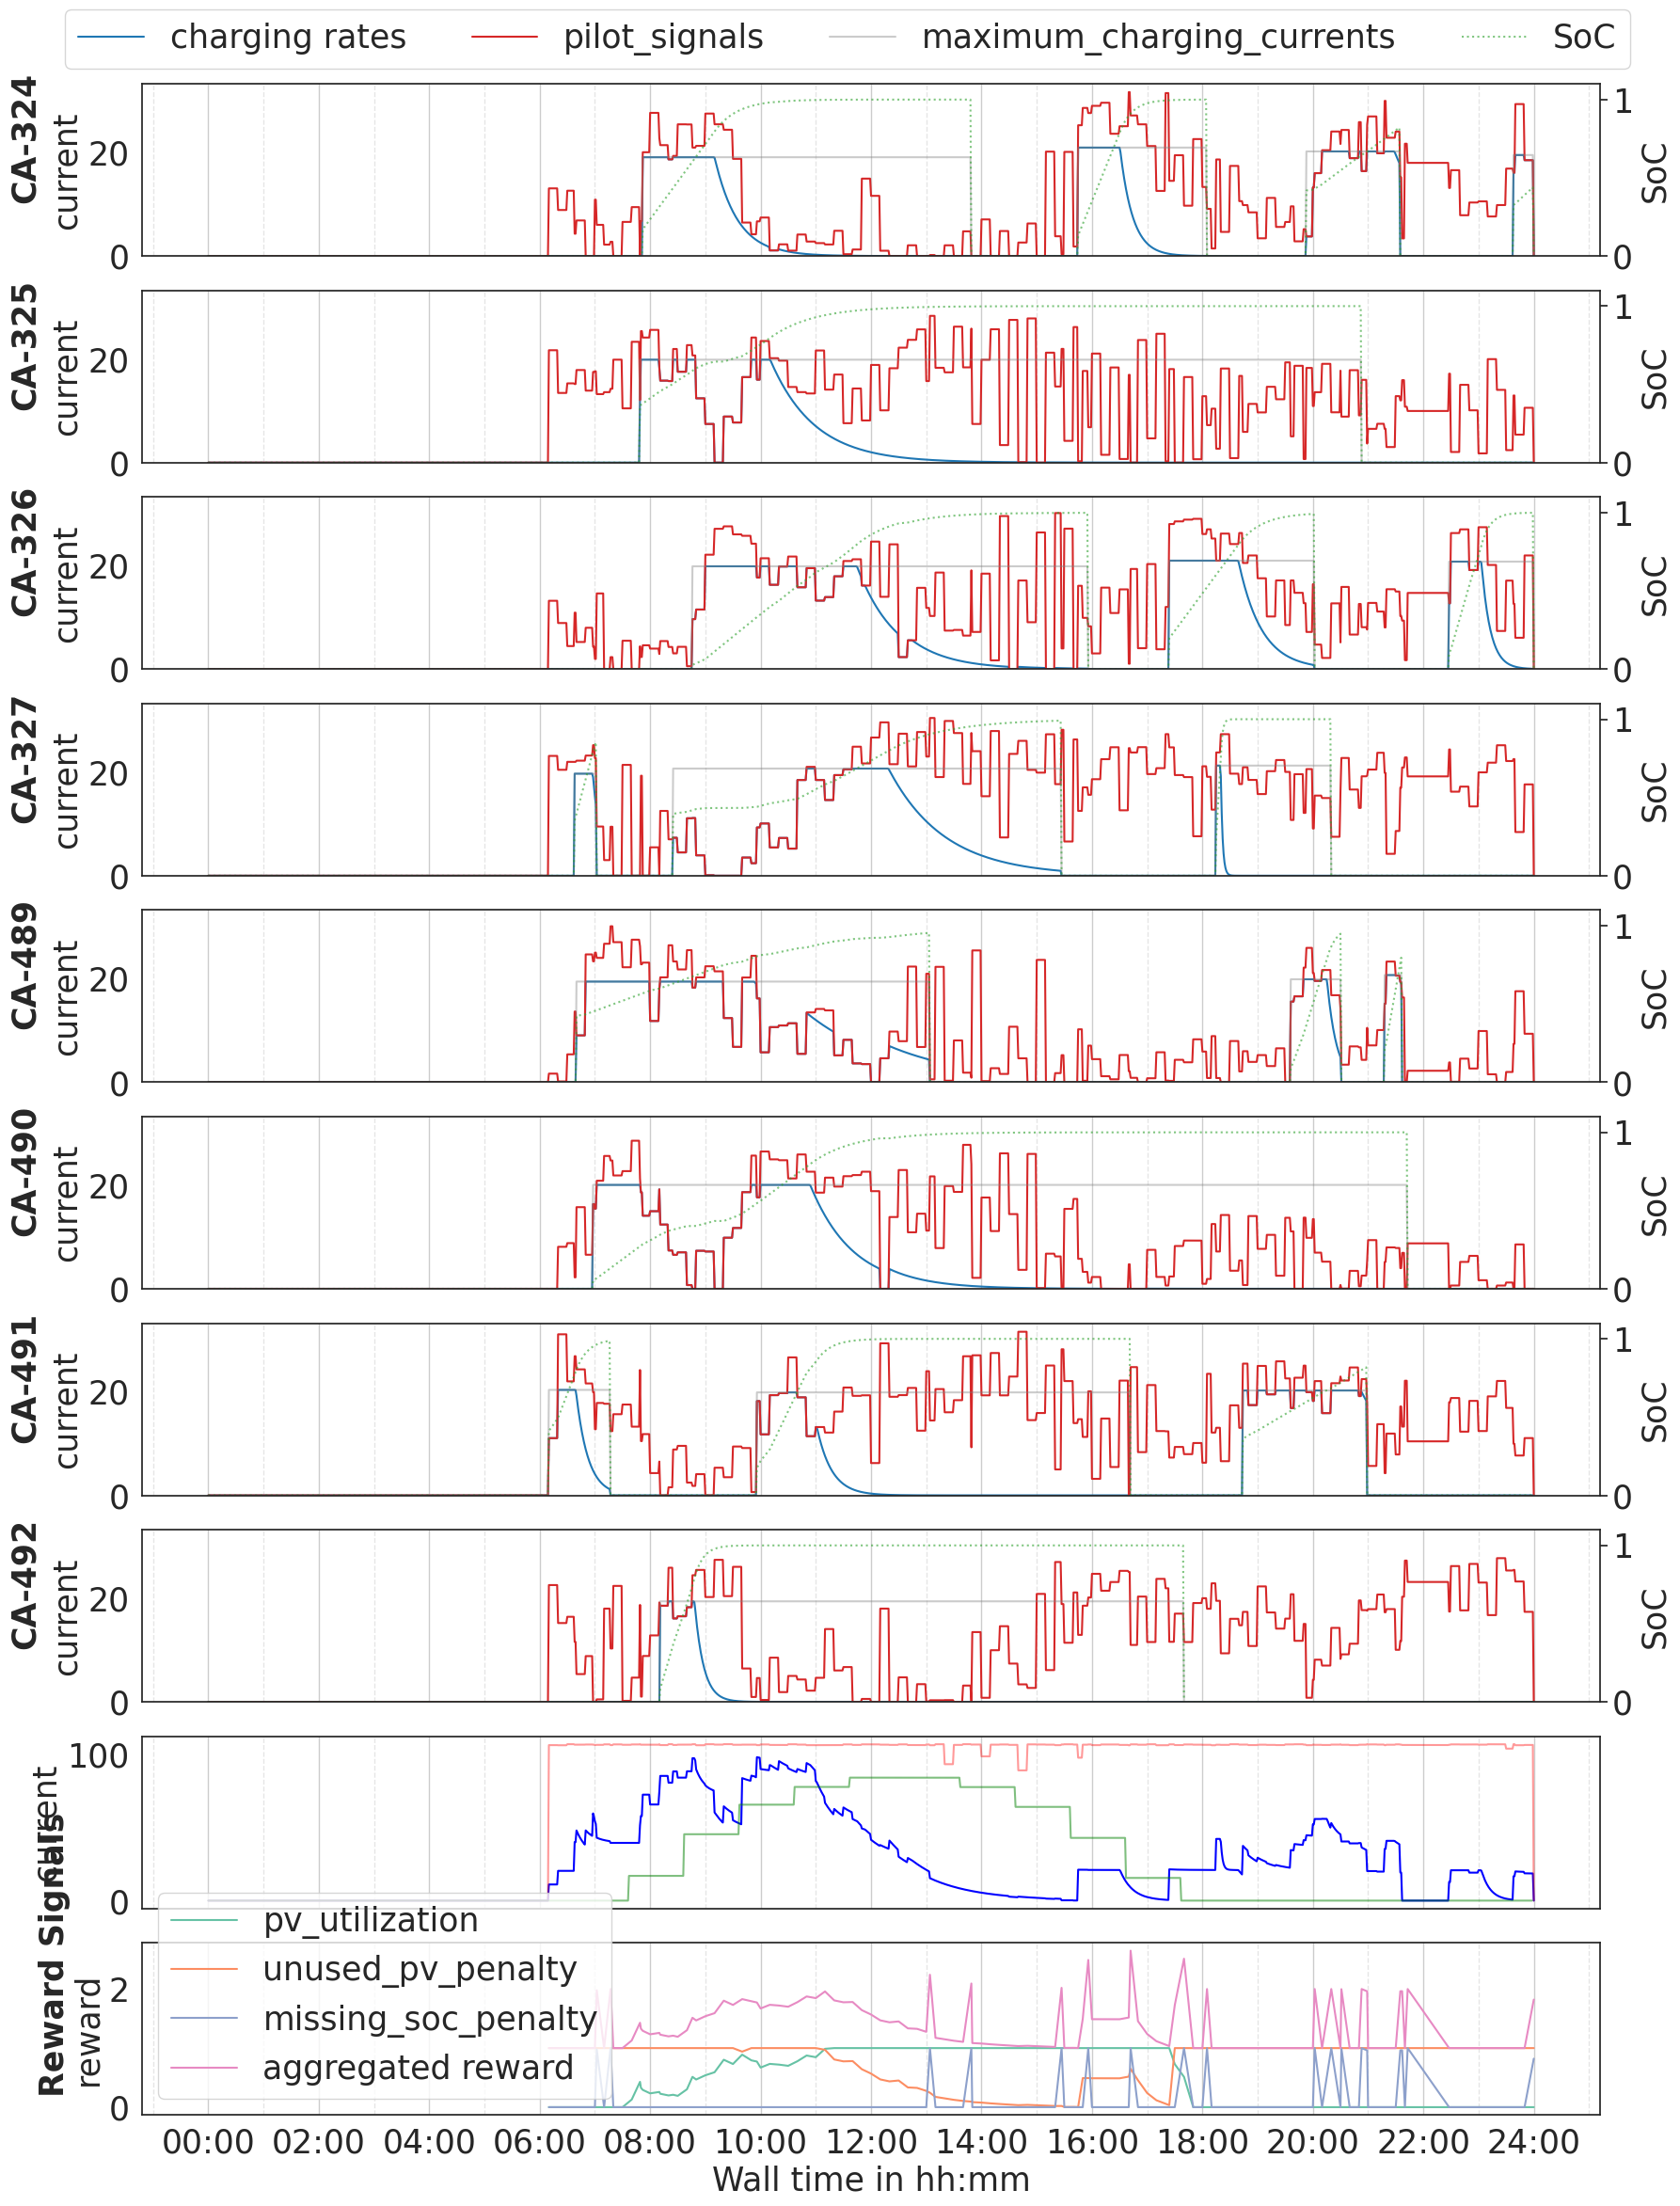

In [ ]:
m = "AUC"

sim = simulations[m][0]
fig = plot_sim_evaluation_pv(sim, df_pv, plot_rewards=True)
fig.savefig(f"behavior_{m}.pdf", dpi=300, bbox_inches="tight")